# Dollar Cost Averaging into an ETF

<b> YouTube Tutorial </b> (Published: Jun 20, 2021): https://youtu.be/NSyli1E53Fk

Let's use backtrader to assess how the dollar cost averaging strategy would have done historically in a Vanguard ETF VTS which follows the S&P500.

In [ ]:
## This is required for pandas_datareader on google colab - then you need to restart runtime
!pip install --upgrade pandas_datareader

## pip install backtrader
!pip install backtrader

     |████████████████████████████████| 109 kB 5.0 MB/s 
  Attempting uninstall: pandas-datareader
    Found existing installation: pandas-datareader 0.9.0
    Uninstalling pandas-datareader-0.9.0:
      Successfully uninstalled pandas-datareader-0.9.0
     |████████████████████████████████| 410 kB 4.7 MB/s 


In [ ]:
import datetime
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
import backtrader as bt

# import data
def get_data(stocks, start, end):
    stockData = pdr.get_data_yahoo(stocks, start, end)
    return stockData

stockList = ['VTS.AX']
endDate = datetime.datetime.now()
startDate = endDate - datetime.timedelta(days=1800)

stockData = get_data(stockList[0], startDate, endDate)

actualStart = stockData.index[0]

data = bt.feeds.PandasData(dataname=stockData)

## Create Strategy Class to define the dollar cost average strat

Here we have two strats:
 - buy and hold
 - continuous dollar cost averaging

In [ ]:
class BuyAndHold(bt.Strategy):
    def start(self):
        self.val_start = self.broker.get_cash()

    def nextstart(self):
        size = math.floor( (self.broker.get_cash() - 10) / self.data[0] )
        self.buy(size=size)

    def stop(self):
        # calculate actual returns
        self.roi = (self.broker.get_value() / self.val_start) - 1
        print('-'*50)
        print('BUY & HOLD')
        print('Starting Value:  ${:,.2f}'.format(self.val_start))
        print('ROI:              {:.2f}%'.format(self.roi * 100.0))
        print('Annualised:       {:.2f}%'.format(100*((1+self.roi)**(365/(endDate-actualStart).days) -1)))
        print('Gross Return:    ${:,.2f}'.format(self.broker.get_value() - self.val_start))

class BuyAndHold_More_Fund(bt.Strategy):
    params = dict(
        monthly_cash=1000,
        monthly_range=[5,20]
    )

    def __init__(self):
        self.order = None
        self.totalcost = 0
        self.cost_wo_bro = 0
        self.units = 0
        self.times = 0

    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def start(self):
        self.broker.set_fundmode(fundmode=True, fundstartval=100.0)

        self.cash_start = self.broker.get_cash()
        self.val_start = 100.0

        # ADD A TIMER
        self.add_timer(
            when=bt.timer.SESSION_START,
            monthdays=[i for i in self.p.monthly_range],
            monthcarry=True
            # timername='buytimer',
        )

    def notify_timer(self, timer, when, *args):
        self.broker.add_cash(self.p.monthly_cash)

        target_value = self.broker.get_value() + self.p.monthly_cash - 10
        self.order_target_value(target=target_value)

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return

        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price %.2f, Cost %.2f, Comm %.2f, Size %.0f' %
                    (order.executed.price,
                    order.executed.value,
                    order.executed.comm,
                    order.executed.size)
                )

                self.units += order.executed.size
                self.totalcost += order.executed.value + order.executed.comm
                self.cost_wo_bro += order.executed.value
                self.times += 1

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')
            print(order.status, [order.Canceled, order.Margin, order.Rejected])

        self.order = None

    def stop(self):
        # calculate actual returns
        self.roi = (self.broker.get_value() / self.cash_start) - 1
        self.froi = (self.broker.get_fundvalue() - self.val_start)
        value = self.datas[0].close * self.units + self.broker.get_cash()
        print('-'*50)
        print('BUY & BUY MORE')
        print('Time in Market: {:.1f} years'.format((endDate - actualStart).days/365))
        print('#Times:         {:.0f}'.format(self.times))
        print('Value:         ${:,.2f}'.format(value))
        print('Cost:          ${:,.2f}'.format(self.totalcost))
        print('Gross Return:  ${:,.2f}'.format(value - self.totalcost))
        print('Gross %:        {:.2f}%'.format((value/self.totalcost - 1) * 100))
        print('ROI:            {:.2f}%'.format(100.0 * self.roi))
        print('Fund Value:     {:.2f}%'.format(self.froi))
        print('Annualised:     {:.2f}%'.format(100*((1+self.froi/100)**(365/(endDate - actualStart).days) - 1)))
        print('-'*50)

## Fixed commission Scheme
 - realistic for ETF transaction at $1000 per trade

In [ ]:
class FixedCommisionScheme(bt.CommInfoBase):
    paras = (
        ('commission', 10),
        ('stocklike', True),
        ('commtype', bt.CommInfoBase.COMM_FIXED)
    )

    def _getcommission(self, size, price, pseudoexec):
        return self.p.commission

## Define run function to access strats

In [ ]:
def run(data):
    # BUY and HOLD
    cerebro = bt.Cerebro()
    cerebro.adddata(data)
    cerebro.addstrategy(BuyAndHold)

    # Broker Information
    broker_args = dict(coc=True)
    cerebro.broker = bt.brokers.BackBroker(**broker_args)
    comminfo = FixedCommisionScheme()
    cerebro.broker.addcommissioninfo(comminfo)

    cerebro.broker.set_cash(100000)

    # BUY and BUY MORE
    cerebro1 = bt.Cerebro()
    cerebro1.adddata(data)
    cerebro1.addstrategy(BuyAndHold_More_Fund)

    # Broker Information
    broker_args = dict(coc=True)
    cerebro1.broker = bt.brokers.BackBroker(**broker_args)
    comminfo = FixedCommisionScheme()
    cerebro1.broker.addcommissioninfo(comminfo)

    cerebro1.broker.set_cash(1000)

    cerebro1.run()
    cerebro.run()
    cerebro.plot(iplot=False, style='candlestick')
    cerebro1.plot(iplot=False, style='candlestick')

2017-03-13, BUY EXECUTED, Price 160.80, Cost 1929.60, Comm 0.00, Size 12
2017-04-06, BUY EXECUTED, Price 159.79, Cost 958.74, Comm 0.00, Size 6
2017-04-21, BUY EXECUTED, Price 160.29, Cost 961.74, Comm 0.00, Size 6
2017-05-08, BUY EXECUTED, Price 166.15, Cost 996.90, Comm 0.00, Size 6
2017-05-23, BUY EXECUTED, Price 164.66, Cost 987.96, Comm 0.00, Size 6
2017-06-06, BUY EXECUTED, Price 168.11, Cost 1008.66, Comm 0.00, Size 6
2017-06-21, BUY EXECUTED, Price 165.94, Cost 995.64, Comm 0.00, Size 6
2017-07-06, BUY EXECUTED, Price 163.79, Cost 1146.53, Comm 0.00, Size 7
2017-07-21, BUY EXECUTED, Price 160.36, Cost 962.16, Comm 0.00, Size 6
2017-08-08, BUY EXECUTED, Price 160.15, Cost 960.90, Comm 0.00, Size 6
2017-09-06, BUY EXECUTED, Price 159.64, Cost 957.84, Comm 0.00, Size 6
2017-09-21, BUY EXECUTED, Price 160.82, Cost 964.92, Comm 0.00, Size 6
2017-10-08, BUY EXECUTED, Price 169.33, Cost 1015.98, Comm 0.00, Size 6
2017-10-23, BUY EXECUTED, Price 169.25, Cost 1015.50, Comm 0.00, Size 6


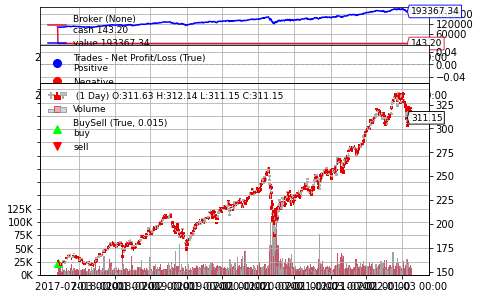

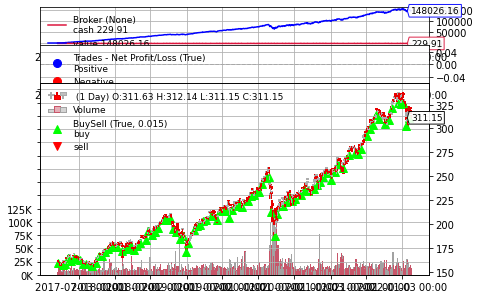

In [ ]:
run(data)